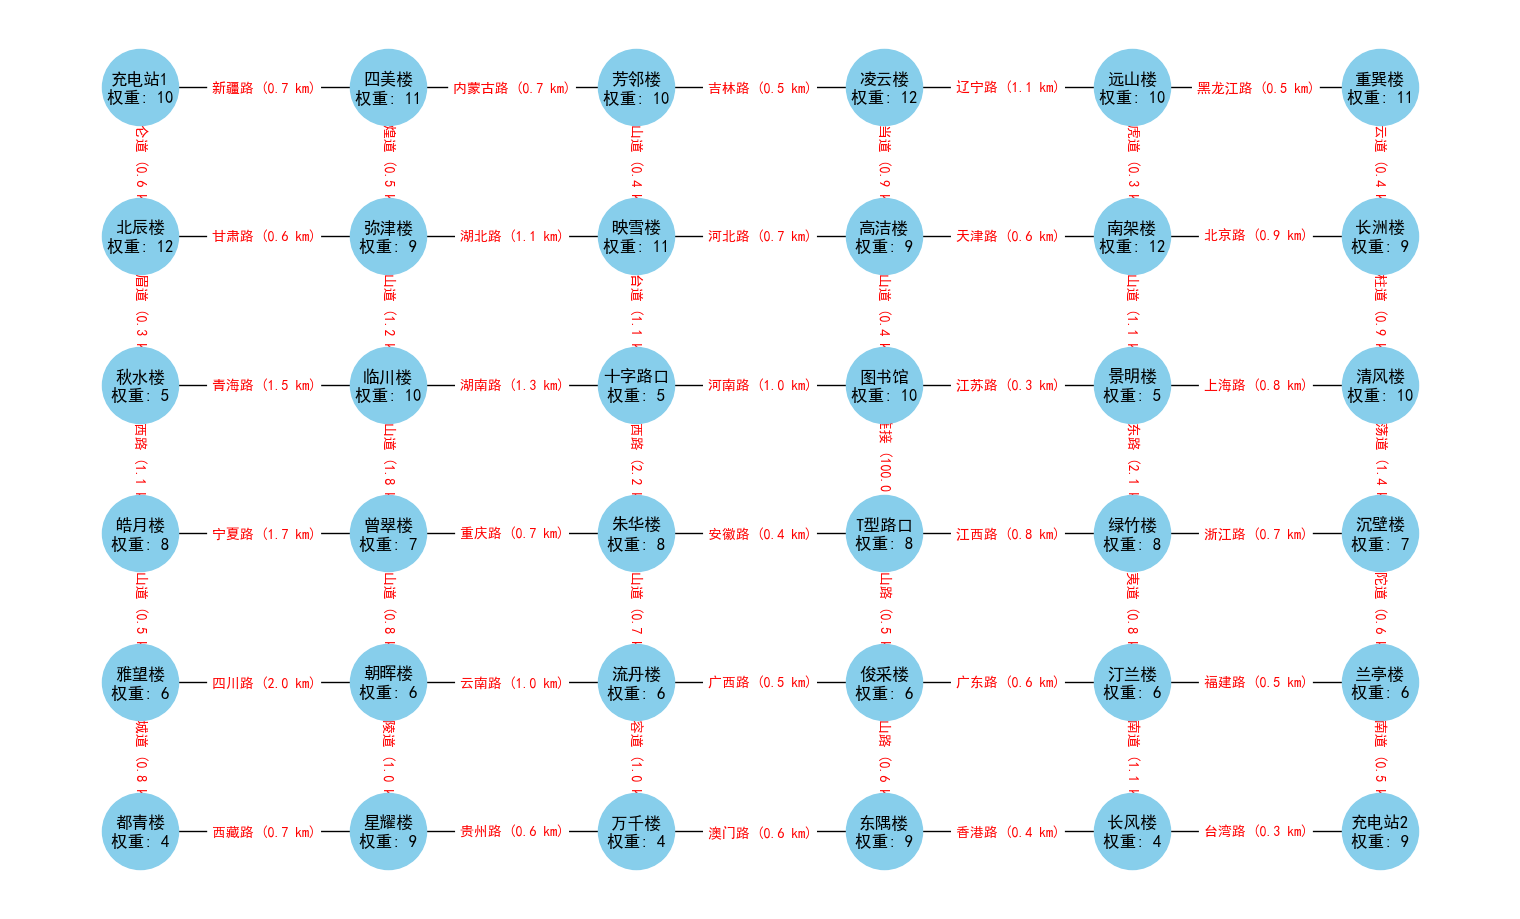

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'SimHei'

road_distance_data = pd.read_csv('road_distance_data.csv')
borrow_data = pd.DataFrame({
    '楼宇名称': ['充电站1', '北辰楼', '秋水楼', '皓月楼', '雅望楼', '都青楼',
             '四美楼', '弥津楼', '临川楼', '曾翠楼', '朝晖楼', '星耀楼',
             '芳邻楼', '映雪楼', '十字路口', '朱华楼', '流丹楼', '万千楼',
             '凌云楼', '高洁楼', '图书馆', 'T型路口', '俊采楼', '东隅楼',
             '远山楼', '南架楼', '景明楼', '绿竹楼', '汀兰楼', '长风楼',
             '重巽楼', '长洲楼', '清风楼', '沉壁楼', '兰亭楼', '充电站2'],
    '权重': [10, 12, 5, 8, 6, 4, 11, 9, 10, 7, 6, 9, 10, 11, 5, 8, 6, 4, 12, 9, 10, 8, 6, 9, 10, 12, 5, 8, 6, 4, 11, 9, 10, 7, 6, 9]
})

def build_transposed_graph(borrow_data, road_data):
    G = nx.Graph()

    for idx, row in borrow_data.iterrows():
        G.add_node(row['楼宇名称'], weight=row['权重'])

    nodes = borrow_data['楼宇名称'].tolist()
    road_counter = 0

    for j in range(6):
        for i in range(5):
            start_node = nodes[i*6 + j]
            end_node = nodes[(i+1)*6 + j]
            road_name = road_data.iloc[road_counter]['道路名称']
            road_length = road_data.iloc[road_counter]['实际距离']
            G.add_edge(start_node, end_node, road=road_name, length=road_length)
            road_counter += 1

    for i in range(6):
        for j in range(5):
            start_node = nodes[i*6 + j]
            end_node = nodes[i*6 + j + 1]
            road_name = road_data.iloc[road_counter]['道路名称']
            road_length = road_data.iloc[road_counter]['实际距离']
            G.add_edge(start_node, end_node, road=road_name, length=road_length)
            road_counter += 1

    return G

G_transposed = build_transposed_graph(borrow_data, road_distance_data)

nodes = borrow_data['楼宇名称'].tolist()
transposed_positions = [(j, i) for i in range(6) for j in range(6)]
transposed_node_positions = dict(zip(nodes, transposed_positions))
transposed_pos = {node: (y, -x) for node, (x, y) in transposed_node_positions.items()}
edge_labels_transposed = nx.get_edge_attributes(G_transposed, 'road')

edge_labels_with_distance = {(u, v): f"{d['road']} ({d['length']} km)" for u, v, d in G_transposed.edges(data=True)}

node_labels = {node: f"{node}\n权重: {G_transposed.nodes[node]['weight']}" for node in G_transposed.nodes()}

plt.figure(figsize=(15, 9))
nx.draw(G_transposed, transposed_pos, labels=node_labels, with_labels=True, font_weight='bold', node_size=3000, node_color='skyblue')
nx.draw_networkx_edge_labels(G_transposed, transposed_pos, edge_labels=edge_labels_with_distance, font_color='red')

plt.show()

In [2]:
import numpy as np
import random

# 计算 PageRank 和中介中心性
pagerank_values = nx.pagerank(G_transposed, weight='length')
betweenness_centrality_values = nx.betweenness_centrality(G_transposed, weight='length')

# 将结果添加到图的节点属性中
nx.set_node_attributes(G_transposed, pagerank_values, 'pagerank')
nx.set_node_attributes(G_transposed, betweenness_centrality_values, 'betweenness')

# 定义 AttractRank 算法
def attract_rank(G, alpha=0.5, beta=0.5):
    attractiveness = {}
    
    for node in G.nodes:
        pagerank_score = G.nodes[node]['pagerank']
        betweenness_score = G.nodes[node]['betweenness']
        # 计算 AttractRank 分数，alpha 和 beta 是权重因子
        attract_rank_score = alpha * pagerank_score + beta * betweenness_score
        attractiveness[node] = attract_rank_score
        
    return attractiveness

# 计算 AttractRank 值
attract_rank_values = attract_rank(G_transposed)

# 将 AttractRank 结果添加到图的节点属性中
nx.set_node_attributes(G_transposed, attract_rank_values, 'attract_rank')

# 初始化列表来保存每辆车的路径信息
cars_paths = []

for car in range(10):  # 处理10辆车
    # 随机选择不同的道路段来定义起始和结束位置
    start_road_index = np.random.choice(road_distance_data.index)
    end_road_index = np.random.choice(road_distance_data.index)
    while end_road_index == start_road_index:
        end_road_index = np.random.choice(road_distance_data.index)

    # 获取这些道路段的信息
    start_road = road_distance_data.iloc[start_road_index]
    end_road = road_distance_data.iloc[end_road_index]

    start_road_name = start_road['道路名称']
    end_road_name = end_road['道路名称']

    start_road_length = start_road['实际距离']
    end_road_length = end_road['实际距离']

    # 生成起始和结束位置的随机点
    start_position = np.random.uniform(0, start_road_length)
    end_position = np.random.uniform(0, end_road_length)

    # 找到与这些道路段相连的节点
    start_connected_edges = [(u, v) for u, v, d in G_transposed.edges(data=True) if d['road'] == start_road_name]
    end_connected_edges = [(u, v) for u, v, d in G_transposed.edges(data=True) if d['road'] == end_road_name]

    # 随机选择一个连接边作为起点和终点对应的节点
    start_edge = random.choice(start_connected_edges)
    end_edge = random.choice(end_connected_edges)

    # 确定路径的方向，根据起始和结束位置来决定路径
    if start_position < end_position:
        path = nx.dijkstra_path(G_transposed, source=start_edge[0], target=end_edge[1], weight='length')
    else:
        path = nx.dijkstra_path(G_transposed, source=start_edge[1], target=end_edge[0], weight='length')

    # 保存每辆车的路径信息
    cars_paths.append({
        'car_id': car + 1,
        'start_position': (start_edge, start_road_name, start_position),
        'end_position': (end_edge, end_road_name, end_position),
        'path': path
    })

# 输出每辆车的起始位置、结束位置和经过的节点
for car_info in cars_paths:
    print(f"车辆 {car_info['car_id']}:")
    print(f"  起始点位置: {car_info['start_position'][0]} - 道路段: {car_info['start_position'][1]} - 位置: {car_info['start_position'][2]:.2f} km")
    print(f"  结束点位置: {car_info['end_position'][0]} - 道路段: {car_info['end_position'][1]} - 位置: {car_info['end_position'][2]:.2f} km")
    print(f"  经过的节点: {car_info['path']}\n")

车辆 1:
  起始点位置: ('十字路口', '图书馆') - 道路段: 河南路 - 位置: 0.47 km
  结束点位置: ('景明楼', '清风楼') - 道路段: 上海路 - 位置: 0.03 km
  经过的节点: ['图书馆', '景明楼']

车辆 2:
  起始点位置: ('朝晖楼', '星耀楼') - 道路段: 武陵道 - 位置: 0.54 km
  结束点位置: ('都青楼', '星耀楼') - 道路段: 西藏路 - 位置: 0.08 km
  经过的节点: ['星耀楼', '都青楼']

车辆 3:
  起始点位置: ('十字路口', '图书馆') - 道路段: 河南路 - 位置: 0.25 km
  结束点位置: ('清风楼', '沉壁楼') - 道路段: 雁荡道 - 位置: 1.32 km
  经过的节点: ['十字路口', '图书馆', '景明楼', '清风楼', '沉壁楼']

车辆 4:
  起始点位置: ('高洁楼', '南架楼') - 道路段: 天津路 - 位置: 0.24 km
  结束点位置: ('映雪楼', '十字路口') - 道路段: 五台道 - 位置: 0.27 km
  经过的节点: ['高洁楼', '图书馆', '十字路口']

车辆 5:
  起始点位置: ('南架楼', '长洲楼') - 道路段: 北京路 - 位置: 0.87 km
  结束点位置: ('雅望楼', '朝晖楼') - 道路段: 四川路 - 位置: 1.88 km
  经过的节点: ['南架楼', '高洁楼', '图书馆', '十字路口', '朱华楼', '曾翠楼', '朝晖楼']

车辆 6:
  起始点位置: ('曾翠楼', '朝晖楼') - 道路段: 衡山道 - 位置: 0.38 km
  结束点位置: ('北辰楼', '秋水楼') - 道路段: 峨眉道 - 位置: 0.16 km
  经过的节点: ['朝晖楼', '曾翠楼', '皓月楼', '秋水楼', '北辰楼']

车辆 7:
  起始点位置: ('汀兰楼', '兰亭楼') - 道路段: 福建路 - 位置: 0.08 km
  结束点位置: ('景明楼', '绿竹楼') - 道路段: 山东路 - 位置: 1.93 km
  经过的节点: ['汀兰楼', '绿竹楼']

车辆 8:
 